In [3]:
import pandas as pd 
from utils.sentiment import SentimentAnalyzer
model = SentimentAnalyzer()
model.get_sentiment("I am happy")

Device set to use cpu


{'sentiment': 'neutral', 'confidence': 0.8387846350669861}

In [13]:
from transformers import BertTokenizerFast, BertForTokenClassification

model_dir = "D:/thesis/implementation/models/pretrained_models/ComBERT/ComBERT"

# Load fast tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained(model_dir)
model = BertForTokenClassification.from_pretrained(model_dir)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at D:/thesis/implementation/models/pretrained_models/ComBERT/ComBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
import numpy as np
from data.const import MODEL_CLASSES
from data.data_loader import CommodityDataset, pad
from data.data_loader import all_triggers_tag, trigger_tag2idx, idx2trigger_tag, \
                             all_entities, entity2idx, idx2entity, \
                             all_postags, postag2idx, idx2postag, \
                             all_arguments, argument2idx, idx2argument, \
                             all_arguments_tag, argument_tag2idx, idx2argument_tag, \
                             all_modality, modality2idx, idx2modality, \
                             all_polarity, polarity2idx, idx2polarity, \
                             all_deptags, deptags2idx, idx2deptags 
from models.event_extraction import EventExtractor
from utils.helper_functions import preprocessing
from collections import OrderedDict
from spacy.lang.en import English
nlp = English()

def get_valid_pos_tags(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]
def get_dependency_heads(text):
    doc = nlp(text)
    return [token.head.i for token in doc]

# Example usage:
input_text = "BlackRock profit beats Street estimates..."
pos_tags = get_valid_pos_tags(input_text)  # Real POS tags instead of dummy data
def extract_events(input_text, model, tokenizer, args, device):
    inputs = tokenizer(input_text, return_tensors="pt", return_offsets_mapping=True, padding=True, truncation=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])  # Convert input_ids to tokens
    word_ids = inputs.word_ids()  # Map subwords to original words

    # Extract input_ids and attention_mask
    tokens_x_2d = inputs["input_ids"].tolist()
    attention_mask = inputs["attention_mask"].tolist()

    # Provide mock-up for head_indexes_2d (replace with real dependency parsing data)
    head_indexes_2d = [[0] * len(tokens) for tokens in tokens_x_2d]

    # Preprocess the tokens and attention mask
    tokens_x_2d, selected_pos, selected_entity, attention_mask = preprocessing(tokens_x_2d, head_indexes_2d)

    # Move tensors to the device
    tokens_x_2d = torch.LongTensor(tokens_x_2d).to(device)
    selected_pos = torch.LongTensor(selected_pos).to(device)
    selected_entity = torch.LongTensor(selected_entity).to(device)
    attention_mask = torch.LongTensor(attention_mask).to(device)

    # Run inference
    with torch.no_grad():
        encoded_tokens = model.encode_tokens(tokens_x_2d, attention_mask)
        _, event_type_predictions = model.classify_event(encoded_tokens, selected_pos, selected_entity)

    # Map predictions to labels
    preds_np = event_type_predictions.cpu().numpy().squeeze()
    triggers = [idx2trigger_tag[idx] for idx in preds_np]

    # Align triggers with words (not subwords)
    word_to_trigger = {}
    for idx, word_id in enumerate(word_ids):
        if word_id is not None:
            if word_id not in word_to_trigger:
                word_to_trigger[word_id] = []
            word_to_trigger[word_id].append(triggers[idx])

    # Combine triggers for subwords into a single trigger for the word
    final_mapping = {}
    for word_id, trigger_list in word_to_trigger.items():
        # Take the first trigger for the word (or use a more sophisticated aggregation)
        final_mapping[word_id] = trigger_list[0]

    # Map word IDs back to the original text
    words = input_text.split()
    text_to_triggers = []
    for word_id, word in enumerate(words):
        trigger = final_mapping.get(word_id, "O")  # Default to "O" (no trigger)
        text_to_triggers.append((word, trigger))

    return text_to_triggers


# Example usage
if __name__ == "__main__":
    # Set default arguments for Jupyter Notebook usage
    class Args:
        train_data_file = "dataset/event_extraction_train.json"
        eval_data_file = "dataset/event_extraction_test.json"
        batch_size = 4
        transformer_type = "combert"
        learning_rate = 0.00002
        n_epochs = 1
        postag_embedding_dim = 50
        deptags_embedding_dim = 50
        trigger_embedding_dim = 50
        entity_embedding_dim = 50
        GCN_hidden_dim = 200
        GCN_num_layers = 2
        DIST = 1
        bidirectional = True
        n_layers = 2
        dropout = 0.25

    args = Args()
    device = torch.device('cpu')
    model = EventExtractor(args, event_size=len(all_triggers_tag),
                           argument_size=len(all_arguments), argument_tags_size=len(all_arguments_tag),
                           entity_size=len(all_entities), postag_size=len(all_postags),
                           deptags_size=len(all_deptags), trigger_size=len(all_triggers_tag))
    model_dir = "D:/thesis/implementation/models/pretrained_models/ComBERT/ComBERT/pytorch_model.bin"
    state_dict = torch.load(model_dir, map_location=torch.device('cpu'))
    # new_state_dict = OrderedDict()
    # for k, v in state_dict.items():
    #     if k.startswith("bert."):
    #         new_key = k.replace("bert.", "transformer.")
    #         new_state_dict[new_key] = v
    #     elif k.startswith("module.bert."):
    #         new_key = k.replace("module.bert.", "transformer.")
    #         new_state_dict[new_key] = v
    #     elif k.startswith("cls.predictions."):
    #         # Skip keys related to classification head
    #         continue
    #     else:
    #         new_state_dict[k] = v
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    model.to(device)

    tokenizer = MODEL_CLASSES[args.transformer_type][2].from_pretrained(MODEL_CLASSES[args.transformer_type][3])
    input_text = "Fritsch said a positive number could put the brake on further price losses but was unlikely to push prices up , given the market 's reaction to the ADP employment number on Wednesday ."
    text_to_triggers  = extract_events(input_text, model, tokenizer, args, device)
    print("Text to Triggers Mapping:") 
    for word, trigger in text_to_triggers:
        print(f"{word}: {trigger}")


d:\thesis\implementation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text to Triggers Mapping:
Fritsch: I-GEOPOLITICAL-TENSION
said: I-OVERSUPPLY
a: I-SITUATION_DETERIORATE
positive: I-GEOPOLITICAL-TENSION
number: I-OVERSUPPLY
could: I-OVERSUPPLY
put: I-CAUSE-MOVEMENT-UP-GAIN
the: B-MOVEMENT-UP-GAIN
brake: I-OVERSUPPLY
on: B-CAUSE-MOVEMENT-DOWN-LOSS
further: I-OVERSUPPLY
price: I-OVERSUPPLY
losses: I-OVERSUPPLY
but: B-SHORTAGE
was: I-OVERSUPPLY
unlikely: I-OVERSUPPLY
to: I-GEOPOLITICAL-TENSION
push: I-OVERSUPPLY
prices: I-OVERSUPPLY
up: B-GEOPOLITICAL-TENSION
,: I-OVERSUPPLY
given: I-OVERSUPPLY
the: B-MOVEMENT-UP-GAIN
market: I-OVERSUPPLY
's: B-POSITION-HIGH
reaction: B-POSITION-HIGH
to: B-POSITION-HIGH
the: B-POSITION-HIGH
ADP: B-MOVEMENT-UP-GAIN
employment: I-MOVEMENT-FLAT
number: B-POSITION-HIGH
on: B-GEOPOLITICAL-TENSION
Wednesday: I-OVERSUPPLY
.: B-SITUATION_DETERIORATE


In [21]:
len(triggers)

35

In [ ]:
from transformers import BertTokenizerFast, BertForTokenClassification
import torch


import torch
from data.data_loader import CommodityDataset, pad
from model.event_extraction import EventExtractor
from utils.helper_functions import preprocessing
model_dir = "D:/thesis/implementation/models/pretrained_models/ComBERT/ComBERT"
def extract_events(input_text, model, tokenizer, args, device):
    # Preprocess input
    tokens_x_2d, selected_pos, selected_entity, attention_mask = preprocessing(input_text, tokenizer, args)

    # Move tensors to device
    tokens_x_2d = torch.LongTensor(tokens_x_2d).to(device)
    selected_pos = torch.LongTensor(selected_pos).to(device)
    selected_entity = torch.LongTensor(selected_entity).to(device)
    attention_mask = torch.LongTensor(attention_mask).to(device)

    # Run inference
    with torch.no_grad():
        encoded_tokens = model.encode_tokens(tokens_x_2d, attention_mask)
        event_type_logits, event_type_predictions = model.classify_event(encoded_tokens, selected_pos, selected_entity)

    # Map predictions to labels
    triggers = [idx2trigger_tag[idx] for idx in event_type_predictions.cpu().numpy()]
    return triggers

# Example usage
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = EventExtractor(args, event_size=len(all_triggers_tag))
    model.load_state_dict(torch.load(model_dir))
    model.eval()
    model.to(device)

    tokenizer = MODEL_CLASSES[args.transformer_type][2].from_pretrained(MODEL_CLASSES[args.transformer_type][3])
    input_text = "Your input sentence here."
    triggers = extract_events(input_text, model, tokenizer, args, device)
    print("Extracted Triggers:", triggers)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at D:/thesis/implementation/models/pretrained_models/ComBERT/ComBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'text': '', 'start': 0, 'end': 0}, {'text': 'Microsoft', 'start': 0, 'end': 9}, {'text': 'Open', 'start': 19, 'end': 23}, {'text': 'I', 'start': 24, 'end': 25}, {'text': 'in', 'start': 26, 'end': 28}, {'text': 'B', 'start': 34, 'end': 35}, {'text': '.', 'start': 40, 'end': 41}]


In [2]:
import requests
import urllib.parse
import json
from user_agent import generate_user_agent
cookie = 'cleared-onetrust-cookies=Thu, 17 Feb 2022 19:17:07 GMT; usprivacy=1---; _lc2_fpi=f511229f0ef8--01jnaz0dpabwth3wedprhhfbe0; _gcl_au=1.1.1373562176.1740903561; permutive-id=40c79d01-2af0-4a43-b1f1-e036981076ca; _fbp=fb.1.1740903561134.887444212517492666; _cb=B3zXvQy-DFICM604F; _scor_uid=e4a1050ae4204e3abceeaf0cf391eb94; _cc_id=88a58455010c9407b15c4748bc701da7; panoramaId_expiry=1741508375669; panoramaId=202dc570fd68d0372e7e1194b94616d539386696998ee50367a5a8137b6c81e2; panoramaIdType=panoIndiv; ajs_anonymous_id=513fc99a-13db-43e2-b228-57ca1ba1b522; _ga=GA1.2.1955516653.1740903562; OneTrustWPCCPAGoogleOptOut=false; _li_dcdm_c=.reuters.com; _lc2_fpi_js=f511229f0ef8--01jnaz0dpabwth3wedprhhfbe0; dicbo_id=%7B%22dicbo_fetch%22%3A1741113130671%7D; _cb_svref=https%3A%2F%2Fwww.bing.com%2F; _parsely_session={%22sid%22:2%2C%22surl%22:%22https://www.reuters.com/business/energy/bailed-out-uniper-repay-27-bln-state-aid-first-quarter-2025-02-25/%22%2C%22sref%22:%22https://www.bing.com/%22%2C%22sts%22:1741113131045%2C%22slts%22:1740903561947}; _parsely_visitor={%22id%22:%22pid=b114016d-25c9-4698-9e64-3377f5ac5b13%22%2C%22session_count%22:2%2C%22last_session_ts%22:1741113131045}; _li_ss=CmgKBgj5ARCZGgoFCAoQmRoKBgikARCbGgoGCN0BEJkaCgUICRCbGgoGCOEBEJsaCgYIgQEQmRoKBgiiARCZGgoJCP____8HEKUaCgYIiQEQmxoKBgilARCZGgoGCNIBEJkaCgUIfhCbGg; __gads=ID=bda0fcb33fa49620:T=1740903576:RT=1741113148:S=ALNI_MahBEHD-x4l5l3EQWrmLM8qMQkIWA; __gpi=UID=000010510b2554c9:T=1740903576:RT=1741113148:S=ALNI_MYlV1Vg016hSsy4J-1SZM56IDFWMA; __eoi=ID=c2d587b42258c9bd:T=1740903576:RT=1741113148:S=AA-AfjYXhxCIaKAYIkAK25_yPzKR; _gid=GA1.2.1594627787.1741113132; RT="z=1&dm=reuters.com&si=wdpf1ww4jpq&ss=m7rd13xf&sl=0&tt=0"; OptanonConsent=isGpcEnabled=0&datestamp=Wed+Mar+05+2025+01%3A32%3A59+GMT%2B0700+(Indochina+Time)&version=202501.1.0&browserGpcFlag=0&isIABGlobal=false&hosts=&consentId=18ce69e9-d5e5-4a7d-8cfe-96cbdaff40ec&interactionCount=0&isAnonUser=1&landingPath=NotLandingPage&groups=1%3A1%2C3%3A1%2CSSPD_BG%3A1%2C4%3A1%2C2%3A1&AwaitingReconsent=false; ABTasty=uid=s325nzw9ks8eb798; ABTastySession=mrasn=&lp=https%253A%252F%252Fwww.reuters.com%252Fbusiness%252Fenergy%252Fbailed-out-uniper-repay-27-bln-state-aid-first-quarter-2025-02-25%252F; _awl=2.1741113196.5-bdf006192533ebc6b882ca5771492231-6763652d617369612d6561737431-0; _chartbeat2=.1740903561905.1741113180397.1001.-2AIDBDkquTC0c7UoCOhZeECSOrSf.2; cto_bundle=lpL_3l9pSndpdHBPcUdPT2cxenZWaG5uWllYaGgwdWozV0NPeUFpU1Z0Y1VkV091SmVZJTJGNlpXRjN5S1RQVmxkdFBkZnRwYUw5V2xBeGZTTjZreEt3QkdUJTJCZDJRMUpDczJNTVFjV0JKMVhKaWJTeFNWZ1JxMVVlRDNOSHV3TUJZSUpkJTJGZUliM2FmR2dwJTJCNGpabE1mT0pCVzdBdyUzRCUzRA; datadome=fBMWjZ0mH1YQEDAFW2P0ax1Ft2lyD01UHw2gqBBOriQkj5xYSv3wPIIqCoqUJm7GK2~7agfrTh1I~jTeJlwzKx7Lii_WaSP7rcdkPVpPCBuDjXdT0uCWZX2X2LsZW1N4; reuters-geo={"country":"-", "region":"-"}; _gat=1; _dd_s=rum=0&expire=1741114236279'
headers = {
    "Referer": "https://www.reuters.com/business/finance/",
    "User-Agent": generate_user_agent(device_type="desktop", os=("mac", "linux")),
    "Accept": "*/*",
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Accept-Language": "en-US,en;q=0.9"
}
params_dict = {
    "arc-site": "reuters",
    "fetch_type": "collection",
    "offset": 199,
    "section_id": "/markets/us/",
    "size": 9,
    "website": "reuters"
}
json_query = json.dumps(params_dict)

# URL encode the JSON string
encoded_query = urllib.parse.quote(json_query)

res = requests.get(f"https://www.reuters.com/pf/api/v3/content/fetch/articles-by-section-alias-or-id-v1?query={encoded_query}&mxId=00000000&_website=reuters", headers=headers)
res.text


'{"statusCode":200,"message":"Success","result":{"response_time":1742525072380,"parent_section_name":"Markets","pagination":{"size":9,"expected_size":9,"orderby":"display_date:desc"},"date_modified":"2025-02-21T00:00:54Z","fetch_type":"collection","articles":[{"id":"BY5S7XQQRRIFTGLLE7657NIJFA","canonical_url":"/markets/us/futures-fall-markets-assess-tariffs-geopolitical-risks-2025-02-20/","website":"reuters","web":"Wall St ends lower as weak Walmart guidance prompts consumer demand worries","native":"Wall St ends lower as weak Walmart guidance prompts consumer demand worries","headline_feature":"US STOCKS","updated_time":"2025-02-21T00:01:34.112Z","published_time":"2025-02-20T10:27:30.12Z","article_type":"Standard","display_my_news":true,"display_newsletter_signup":true,"display_notifications":true,"display_related_media":true,"display_related_organizations":true,"content_code":"metered","source":{"name":"Package","original_name":"Reuters"},"company_rics":"9988.HK,HAS.O,MSFT.O,PLTR.O,W

In [3]:
res.json()

{'statusCode': 200,
 'message': 'Success',
 'result': {'response_time': 1742525072380,
  'parent_section_name': 'Markets',
  'pagination': {'size': 9,
   'expected_size': 9,
   'orderby': 'display_date:desc'},
  'date_modified': '2025-02-21T00:00:54Z',
  'fetch_type': 'collection',
  'articles': [{'id': 'BY5S7XQQRRIFTGLLE7657NIJFA',
    'canonical_url': '/markets/us/futures-fall-markets-assess-tariffs-geopolitical-risks-2025-02-20/',
    'website': 'reuters',
    'web': 'Wall St ends lower as weak Walmart guidance prompts consumer demand worries',
    'native': 'Wall St ends lower as weak Walmart guidance prompts consumer demand worries',
    'headline_feature': 'US STOCKS',
    'updated_time': '2025-02-21T00:01:34.112Z',
    'published_time': '2025-02-20T10:27:30.12Z',
    'article_type': 'Standard',
    'display_my_news': True,
    'display_newsletter_signup': True,
    'display_notifications': True,
    'display_related_media': True,
    'display_related_organizations': True,
    'c

In [4]:
# Cell 2: Import Libraries
import warnings
warnings.filterwarnings("ignore")
from utils.data_loader import NewsDataHandler, download_stock_data, clean_stock_data
from utils.sentiment import SentimentAnalyzer
from models.decay_models import ExponentialDecay
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [ ]:
from user_agent import generate_user_agent
headers
# res = requests.get("https://www.reuters.com/archive/2017-01/")


'<html lang="en"><head><title>reuters.com</title><style>#cmsg{animation: A 1.5s;}@keyframes A{0%{opacity:0;}99%{opacity:0;}100%{opacity:1;}}</style></head><body style="margin:0"><p id="cmsg">Please enable JS and disable any ad blocker</p><script data-cfasync="false">var dd={\'rt\':\'c\',\'cid\':\'AHrlqAAAAAMAggH8UOJOWZAA-YZXQg==\',\'hsh\':\'2013457ADA70C67D6A4123E0A76873\',\'t\':\'bv\',\'qp\':\'\',\'s\':43909,\'e\':\'5cd6e897a92bbc7aff6066dba3ca1c84c2c3d5dbc36540b22b5a70734af5b406\',\'host\':\'geo.captcha-delivery.com\',\'cookie\':\'mb1oRrLit~4UmkPkBrBtR6xE95rtzvkZ8d8g5rGxfR3FbcnoMTG_EjBJV~CjYvWHQ03eTslaV0prJ4cspAs_BcfJwBPACDxTtpefTxbE~M9_8d5Fqlt02QFZAg80NIDl\'}</script><script data-cfasync="false" src="https://ct.captcha-delivery.com/c.js"></script></body></html>'

In [5]:
# Cell 3: Load and Filter News Data
news_handler = NewsDataHandler(news_path="data/raw_news/reuters_headlines.csv")
start_date = pd.to_datetime("2018-03-20")
end_date = pd.to_datetime("2020-07-18")
filtered_news = news_handler.filter_by_time_range(start_date, end_date)

# Display first 5 rows of filtered news
filtered_news.head()

,Headlines,Time,Description
0,TikTok considers London and other locations fo...,2020-07-18,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,2020-07-18,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,2020-07-18,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,2020-07-18,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,2020-07-17,A battle in the U.S. Congress over a new coron...


In [6]:
# Cell 4: Load Stock Data
down_path = "data/raw_stocks/MSFT_raw.csv"
output_path = "data/raw_stocks/MSFT_cleaned.csv"
try:
    stock_data = pd.read_csv(output_path, parse_dates=["Date"])
except FileNotFoundError:
    print("Downloading stock data...")
    download_stock_data(
        symbol="MSFT",
        start_date="2018-03-20",
        end_date="2020-07-18",
        output_path=down_path,
    )
    clean_stock_data(
        input_path=down_path,
        output_path=output_path,
    )
    stock_data = pd.read_csv(output_path, parse_dates=["Date"])

# Display first 5 rows of stock data
stock_data.head()

,Date,Close,High,Low,Open,Volume
0,2018-03-20,86.691177,87.286928,86.570168,86.616714,23075200
1,2018-03-21,86.086113,87.547566,85.834776,86.504998,24457100
2,2018-03-22,83.582092,85.406581,83.461083,84.959764,38604700
3,2018-03-23,81.152542,84.205768,81.059457,83.312141,44068900
4,2018-03-26,87.296234,87.501025,84.149923,84.345403,56396800


In [7]:
# # Cell 5: Align News to Stock Timestamps
# aligned_news = news_handler.align_to_stock_data(stock_data["Date"], time_window="1D")

# # Display first 5 rows of aligned news
# aligned_news.head()

In [8]:
# # Cell 6: Extract Sentiment Scores
# sentiment_analyzer = SentimentAnalyzer()
# aligned_news["combined_text"] = aligned_news["Headlines"] + " " + aligned_news["Description"]
# sentiment_scores = sentiment_analyzer.batch_process(aligned_news["combined_text"].tolist())
# # 
# # Map sentiment to scores: positive=1, negative=-1, neutral=0
# aligned_news["sentiment_score"] = [
#     s["confidence"] * (1 if s["sentiment"] == "positive" else (-1 if s["sentiment"] == "negative" else 0))
#     for s in sentiment_scores
# ]

# # Display first 5 rows with sentiment scores
# aligned_news[["Headlines", "sentiment_score"]].head()

In [9]:
aligned_news = pd.read_csv("results/aligned_news_with_sentiment.csv")
aligned_news["Time"] = pd.to_datetime(aligned_news["Time"])
aligned_news["aligned_stock_time"] = pd.to_datetime(aligned_news["aligned_stock_time"])
aligned_news.head()

,Headlines,Time,Description,aligned_stock_time,combined_text,sentiment_score
0,Asian business sentiment edges up to hit seven...,2018-03-20,Business confidence among Asian companies rose...,2018-03-20,Asian business sentiment edges up to hit seven...,0.952841
1,New Zealand court rejects Megaupload founder's...,2018-03-20,A New Zealand court rejected on Wednesday inte...,2018-03-20,New Zealand court rejects Megaupload founder's...,-0.925582
2,Former PBOC governor: China will continue to a...,2018-03-20,China will continue to adopt a proactive fisca...,2018-03-20,Former PBOC governor: China will continue to a...,0.799818
3,"Blackstone co-founder Peter Peterson dies, age...",2018-03-20,Billionaire Wall Street financier Peter Peters...,2018-03-20,"Blackstone co-founder Peter Peterson dies, age...",0.000000
4,"Expedia's Orbitz says 880,000 payment cards hi...",2018-03-20,"Orbitz, a subsidiary of online travel agency E...",2018-03-20,"Expedia's Orbitz says 880,000 payment cards hi...",-0.939749


In [10]:

decay_model = ExponentialDecay(decay_rate=0.1, period_type="week", period_amount=1)
stock_data["decayed_sentiment"] = decay_model.compute_decayed_scores(
    aligned_news, stock_data["Date"]
)


# decayed_scores = decay_model.compute_decayed_scores(

#     torch.tensor(aligned_news["sentiment_score"].values),

#     aligned_news,  # Pass DataFrame with aligned_stock_time and Time

# )


# Add decayed scores to the aligned_news DataFrame
features = pd.DataFrame({
    "decayed_scores": stock_data["decayed_sentiment"],
    "price": stock_data["Close"],
    "volume": stock_data["Volume"]
})

In [11]:
aligned_news

,Headlines,Time,Description,aligned_stock_time,combined_text,sentiment_score
0,Asian business sentiment edges up to hit seven...,2018-03-20,Business confidence among Asian companies rose...,2018-03-20,Asian business sentiment edges up to hit seven...,0.952841
1,New Zealand court rejects Megaupload founder's...,2018-03-20,A New Zealand court rejected on Wednesday inte...,2018-03-20,New Zealand court rejects Megaupload founder's...,-0.925582
2,Former PBOC governor: China will continue to a...,2018-03-20,China will continue to adopt a proactive fisca...,2018-03-20,Former PBOC governor: China will continue to a...,0.799818
3,"Blackstone co-founder Peter Peterson dies, age...",2018-03-20,Billionaire Wall Street financier Peter Peters...,2018-03-20,"Blackstone co-founder Peter Peterson dies, age...",0.000000
4,"Expedia's Orbitz says 880,000 payment cards hi...",2018-03-20,"Orbitz, a subsidiary of online travel agency E...",2018-03-20,"Expedia's Orbitz says 880,000 payment cards hi...",-0.939749
...,...,...,...,...,...,...
55475,With inflation in India ticking higher it may ...,2020-07-16,"With India's economic growth sputtering, the R...",2020-07-17,With inflation in India ticking higher it may ...,-0.762851
55476,IMF chief warns global economy 'not out of the...,2020-07-16,Global economic activity is picking up after a...,2020-07-17,IMF chief warns global economy 'not out of the...,-0.919306
55477,Trumps tweet support for Goya Foods amid boyco...,2020-07-16,U.S. President Donald Trump and his daughter a...,2020-07-17,Trumps tweet support for Goya Foods amid boyco...,-0.422286
55478,Delayed tax day to bring revenue lift to cash-...,2020-07-16,A downward spiral in revenue in the wake of th...,2020-07-17,Delayed tax day to bring revenue lift to cash-...,-0.964847


In [12]:
# # Cell 8: Prepare Features (Sentiment + Technical Indicators)
daily_sentiment = aligned_news.groupby("aligned_stock_time")["decayed_scores"].sum().reset_index()
daily_sentiment.rename(columns={"aligned_stock_time": "Date"}, inplace=True)
features = pd.merge(
    stock_data,  # Stock data with Date, Close, Volume, etc.
    daily_sentiment,  # Daily aggregated sentiment scores
    on="Date",
    how="left"
)

# Fill missing sentiment scores with 0 (no news on those days)
features["decayed_scores"].fillna(0, inplace=True)

# Display first 5 rows of features
features.head()

KeyError: 'Column not found: decayed_scores'

In [ ]:
aligned_news

,Headlines,Time,Description,aligned_stock_time,combined_text,sentiment_score
0,Asian business sentiment edges up to hit seven...,2018-03-20,Business confidence among Asian companies rose...,2018-03-20,Asian business sentiment edges up to hit seven...,0.952841
1,New Zealand court rejects Megaupload founder's...,2018-03-20,A New Zealand court rejected on Wednesday inte...,2018-03-20,New Zealand court rejects Megaupload founder's...,-0.925582
2,Former PBOC governor: China will continue to a...,2018-03-20,China will continue to adopt a proactive fisca...,2018-03-20,Former PBOC governor: China will continue to a...,0.799818
3,"Blackstone co-founder Peter Peterson dies, age...",2018-03-20,Billionaire Wall Street financier Peter Peters...,2018-03-20,"Blackstone co-founder Peter Peterson dies, age...",0.000000
4,"Expedia's Orbitz says 880,000 payment cards hi...",2018-03-20,"Orbitz, a subsidiary of online travel agency E...",2018-03-20,"Expedia's Orbitz says 880,000 payment cards hi...",-0.939749
...,...,...,...,...,...,...
55475,With inflation in India ticking higher it may ...,2020-07-16,"With India's economic growth sputtering, the R...",2020-07-17,With inflation in India ticking higher it may ...,-0.762851
55476,IMF chief warns global economy 'not out of the...,2020-07-16,Global economic activity is picking up after a...,2020-07-17,IMF chief warns global economy 'not out of the...,-0.919306
55477,Trumps tweet support for Goya Foods amid boyco...,2020-07-16,U.S. President Donald Trump and his daughter a...,2020-07-17,Trumps tweet support for Goya Foods amid boyco...,-0.422286
55478,Delayed tax day to bring revenue lift to cash-...,2020-07-16,A downward spiral in revenue in the wake of th...,2020-07-17,Delayed tax day to bring revenue lift to cash-...,-0.964847


In [ ]:
# Cell 9: Visualize Stock Prices and Sentiment Scores
# Combine stock data and sentiment scores
combined_data = pd.merge(
    stock_data,  # Stock data with Date, Close, etc.
    aligned_news[["aligned_stock_time", "decayed_scores"]],  # Decayed sentiment scores
    left_on="Date",
    right_on="aligned_stock_time",
    how="left"
)

# Fill missing sentiment scores with 0 (no news on those days)
combined_data["decayed_scores"].fillna(0, inplace=True)

# Aggregate sentiment scores by date (if multiple news articles per day)
combined_data = combined_data.groupby("Date").agg({
    "Close": "last",  # Use the last closing price for the day
    "decayed_scores": "sum"  # Sum decayed sentiment scores for the day
}).reset_index()

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot stock prices
ax1.plot(combined_data["Date"], combined_data["Close"], color="blue", label="Stock Price (Close)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price (Close)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis for sentiment scores
ax2 = ax1.twinx()
ax2.plot(combined_data["Date"], combined_data["decayed_scores"], color="red", label="Decayed Sentiment Score")
ax2.set_ylabel("Decayed Sentiment Score", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Add a title and legend
plt.title("Stock Price vs. Decayed Sentiment Score Over Time")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()

KeyError: "['decayed_scores'] not in index"

Correlation between Decayed Sentiment Scores and Stock Price Changes: 0.12


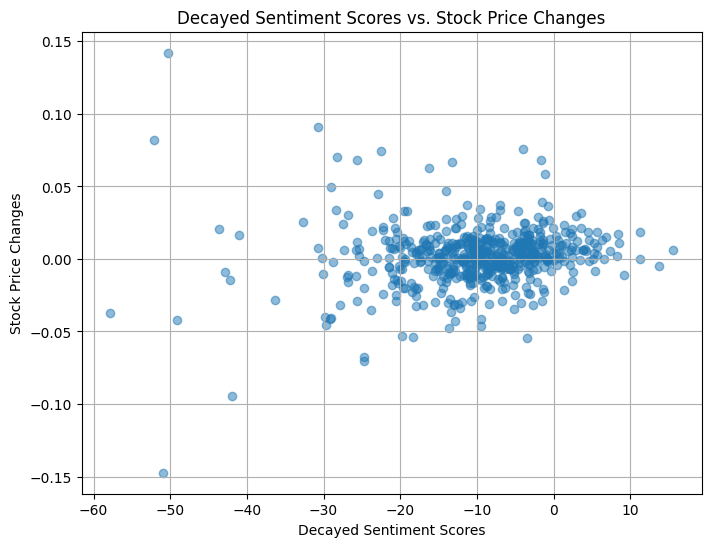

In [ ]:
# Cell 10: Correlation Analysis
# Calculate daily price changes (returns)
combined_data["price_change"] = combined_data["Close"].pct_change()

# Calculate correlation between decayed sentiment scores and price changes
correlation = combined_data["decayed_scores"].corr(combined_data["price_change"])

print(f"Correlation between Decayed Sentiment Scores and Stock Price Changes: {correlation:.2f}")

# Plot scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(combined_data["decayed_scores"], combined_data["price_change"], alpha=0.5)
plt.title("Decayed Sentiment Scores vs. Stock Price Changes")
plt.xlabel("Decayed Sentiment Scores")
plt.ylabel("Stock Price Changes")
plt.grid(True)
plt.show()

Correlation between Lagged Sentiment Scores (1-day) and Stock Price Changes: -0.05


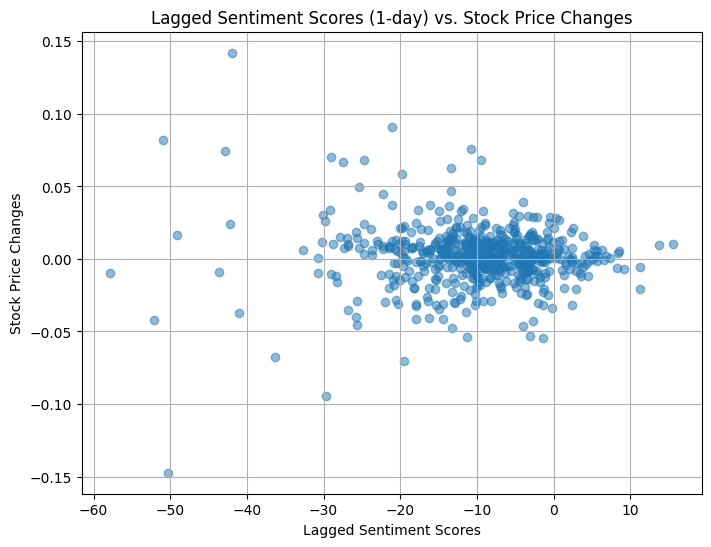

In [ ]:
# Cell 11: Lag Analysis
# Create lagged sentiment scores (e.g., shift by 1 day)
combined_data["lagged_sentiment"] = combined_data["decayed_scores"].shift(1)

# Calculate correlation between lagged sentiment and price changes
lagged_correlation = combined_data["lagged_sentiment"].corr(combined_data["price_change"])

print(f"Correlation between Lagged Sentiment Scores (1-day) and Stock Price Changes: {lagged_correlation:.2f}")

# Plot lagged sentiment vs. price changes
plt.figure(figsize=(8, 6))
plt.scatter(combined_data["lagged_sentiment"], combined_data["price_change"], alpha=0.5)
plt.title("Lagged Sentiment Scores (1-day) vs. Stock Price Changes")
plt.xlabel("Lagged Sentiment Scores")
plt.ylabel("Stock Price Changes")
plt.grid(True)
plt.show()

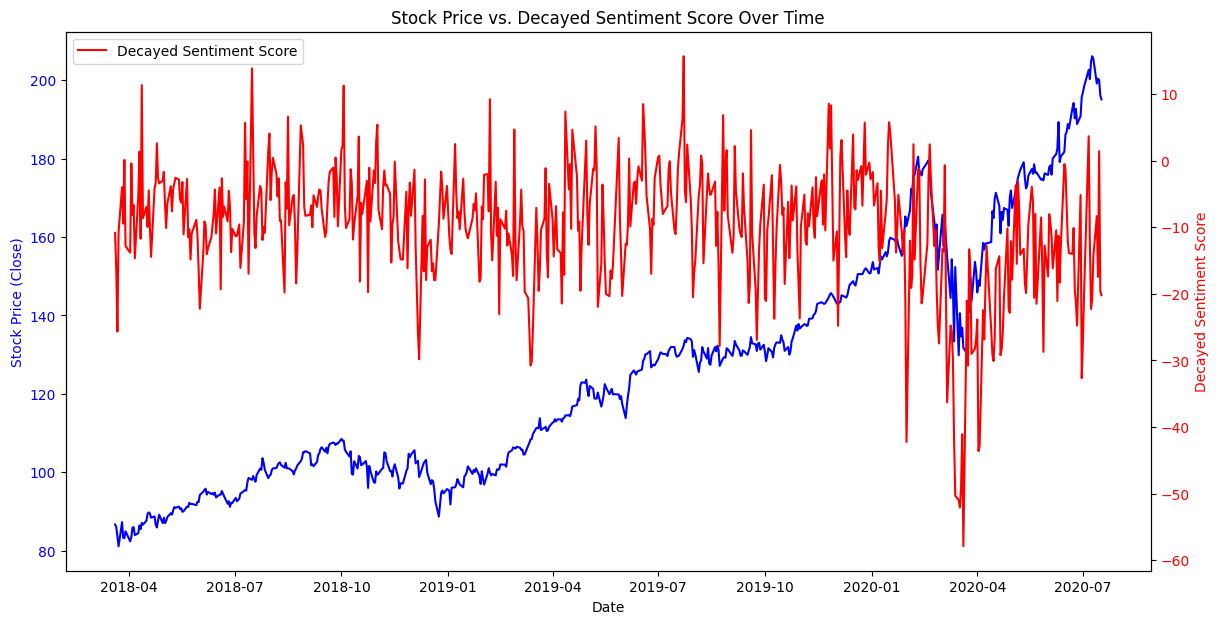

Results saved to 'results/' directory.


In [ ]:
# Cell 12: Save Results
# Save combined data to a CSV file
combined_data.to_csv("results/combined_data.csv", index=False)

# Save the stock price vs. sentiment plot
plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax1.plot(combined_data["Date"], combined_data["Close"], color="blue", label="Stock Price (Close)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price (Close)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(combined_data["Date"], combined_data["decayed_scores"], color="red", label="Decayed Sentiment Score")
ax2.set_ylabel("Decayed Sentiment Score", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Stock Price vs. Decayed Sentiment Score Over Time")
plt.legend(loc="upper left")
plt.savefig("results/stock_price_vs_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()

print("Results saved to 'results/' directory.")

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

class HybridDecayModel(nn.Module):
    def __init__(self, decay_rate=0.15, period_type='day', 
                 use_attention=True, hidden_dim=64):
        super().__init__()
        self.base_decay = self._init_base_decay(decay_rate, period_type)
        self.use_attention = use_attention
        
        if use_attention:
            self.attention = nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1),
                nn.Sigmoid()
            )
            
    def _init_base_decay(self, decay_rate, period_type):
        period_seconds = {
            'hour': 3600,
            'day': 86400,
            'week': 604800
        }[period_type]
        return lambda t: np.exp(-decay_rate * t / period_seconds)
    
    def forward(self, time_deltas, sentiment_scores):
        base_decay = torch.tensor([self.base_decay(t) for t in time_deltas])
        
        if self.use_attention:
            time_features = torch.log1p(time_deltas).unsqueeze(1)
            attention_weights = self.attention(time_features).squeeze()
            combined_decay = base_decay * attention_weights
        else:
            combined_decay = base_decay
            
        return sentiment_scores * combined_decay

class TradingSimulator:
    def __init__(self, initial_capital=1e6, transaction_cost=0.0002):
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        
    def backtest(self, predictions, actual_returns, prices):
        positions = np.zeros_like(predictions)
        capital = self.initial_capital
        portfolio_values = []
        
        for i in range(1, len(predictions)):
            position_change = predictions[i] - positions[i-1]
            transaction_cost = abs(position_change) * prices[i] * self.transaction_cost
            capital -= transaction_cost
            positions[i] = predictions[i]
            
            portfolio_value = capital + positions[i] * prices[i]
            portfolio_values.append(portfolio_value)
            
        returns = pd.Series(portfolio_values).pct_change().dropna()
        return {
            'sharpe_ratio': np.sqrt(252) * returns.mean() / returns.std(),
            'max_drawdown': (portfolio_values / np.maximum.accumulate(portfolio_values) - 1).min(),
            'total_return': portfolio_values[-1] / self.initial_capital - 1
        }

def enhanced_analysis(features, model, lookback=30):
    # Volatility regime analysis
    features['volatility'] = features['price'].pct_change().rolling(lookback).std()
    
    # Decay parameter sensitivity
    decay_rates = np.linspace(0.05, 0.5, 10)
    performances = []
    
    for dr in decay_rates:
        model.decay_model.base_decay = model.decay_model._init_base_decay(dr, 'day')
        preds = model.predict(features)
        mse = mean_squared_error(features['price'].iloc[1:], preds[:-1])
        performances.append(mse)
    
    # Cross-asset correlation
    correlations = features[['decayed_sentiment', 'price', 'volume']].rolling(lookback).corr()
    
    return {
        'volatility_regimes': features.groupby(pd.qcut(features['volatility'], 3))['decayed_sentiment'].mean(),
        'decay_sensitivity': pd.Series(performances, index=decay_rates),
        'rolling_correlations': correlations
    }

# Usage Example
if __name__ == "__main__":
    # Initialize enhanced models
    decay_model = HybridDecayModel(decay_rate=0.15, use_attention=True)
    trading_sim = TradingSimulator()
    
    # Load processed data
    features = pd.read_csv("results/processed_stock_data.csv", parse_dates=['Date'])
    
    # Advanced analysis
    analysis_results = enhanced_analysis(features, model)
    
    # Generate visualizations
    plt.figure(figsize=(12, 6))
    analysis_results['decay_sensitivity'].plot(title='MSE vs Decay Rate')
    plt.xlabel('Decay Rate (λ)')
    plt.ylabel('Prediction MSE')
    plt.savefig('results/decay_sensitivity.png')
    
    # Trading simulation
    predictions = model.predict(features)
    sim_results = trading_sim.backtest(predictions, 
                                     features['price'].pct_change(),
                                     features['price'])
    
    print(f"Sharpe Ratio: {sim_results['sharpe_ratio']:.2f}")
    print(f"Total Return: {sim_results['total_return']:.2%}")

FileNotFoundError: [Errno 2] No such file or directory: 'results/processed_stock_data.csv'